<a href="https://colab.research.google.com/github/apxunov/AuthorizationWithDatabaseDOTENV/blob/master/intel_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <strong>Анализ и прогнозирование временных рядов. Модель ARIMA</strong>

Этот Jupyter Notebook демонстрирует процесс построения модели ARIMA для различных временных рядов.

---

**DISCLAIMER!**

Процесс определения оптимальных параметров модели ARIMA нельзя назвать абсолютно точным! Как и в случае с оптимизацией гиперпараметров моделей машинного обучения, это скорее ряд рекомендаций, как выбрать тот или иной параметр, а не чёткий (и математически доказанный) алгоритм, который вседа приводит к гарантированно правильному результату. Лучший набор параметров - тот, при котором модель лучше всего соответствует наблюдаемым значениям временного ряда и/или даёт наименьшую ошибку на предсказании.

---

<strong>Модель ARIMA($p,d,q$):</strong>

$$ A_p(L) \Delta^d X_t = B_q(L)\varepsilon_t $$

Основные параметры модели:

> $p$ - порядок авторегрессии  
> $q$ - порядок скольящего среднего  
> $d$ - порядок интегрирования (при $d = 0$ получаем модель ARMA($p,q$)

Последовательность действий

1. Данные
2. Параметры $d, p, q$
3. Обучение
4. Диагностика
6. Прогноз

Чтобы всё работало, нам потребуется версия `statsmodels` не ниже 0.12.0

In [ ]:
!pip install statsmodels -U

import statsmodels
print(statsmodels.__version__)

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.12.1)
0.12.1


In [ ]:
import os

import numpy as np
import pandas as pd
import operator

import matplotlib.pyplot as plt

from functools import reduce
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller unit root test
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import AutoReg

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##<h1><strong>INTC Stock</strong></h1>
<p>
В качестве датасета были взяты данные по торгам акций компании Intel в период с 2005 по 2020 гг <br>
<a href="https://finance.yahoo.com/quote/INTC/history?p=INTC">Yahoo! finance</a> 
</p>

### <h2><strong>1. Данные</strong></h2>
Загрузка данных в формате .csv

In [ ]:
intel_csvData_filePath = "/content/drive/MyDrive/Colab Notebooks/Intel/INTC.csv"

In [ ]:
intc_df = pd.read_csv(intel_csvData_filePath, parse_dates=["Date"], usecols=["Date", "Close"], index_col="Date")
print(f'\033[1m Первые 10 строк датасета выглядят следующим образом: \033[0m \n\n {intc_df.head(10)}')
print('\033[1m \n\n В дальнейшем мне будут интересны значения столбца "Close" \033[0m')
intc_df.tail()

 Первые 10 строк датасета выглядят следующим образом:  

                 Close
Date                 
2005-12-22  25.969999
2005-12-23  25.969999
2005-12-27  25.459999
2005-12-28  25.440001
2005-12-29  25.070000
2005-12-30  24.959999
2006-01-03  25.570000
2006-01-04  25.910000
2006-01-05  26.270000
2006-01-06  26.309999
 

 В дальнейшем мне будут интересны значения столбца "Close" 


,Close
Date,
2020-12-15,50.669998
2020-12-16,51.119999
2020-12-17,50.650002
2020-12-18,47.459999
2020-12-21,46.360001


График изменения цены акции Intel с 2005 по 2020 гг

In [ ]:
ts_title = 'INTC Stoke prices (Close)'

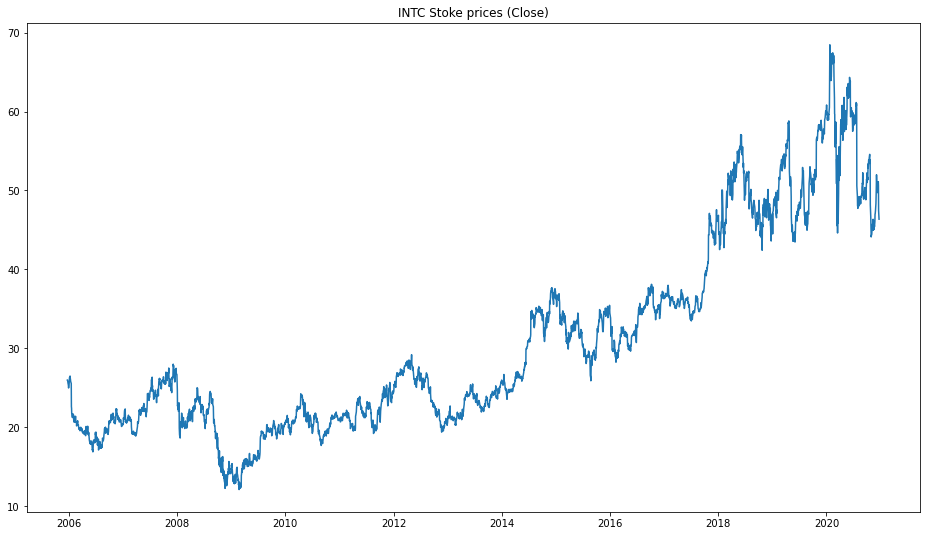

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(intc_df)
plt.title(ts_title)
plt.show()

In [ ]:
intc_StockData = intc_df["Close"]

### <h2><strong>2. Параметры $d, p, q$</strong></h2>

Определяем параметры модели **ARIMA**: $d, p, q$ (именно в этом порядке: сначала $d$, потом $p$ и $q$)

$$ A_p(L) \Delta^d X_t = B_q(L)\varepsilon_t $$

> $p$ - порядок авторегрессии  
> $q$ - порядок скольящего среднего  
> $d$ - порядок интегрирования (при $d = 0$ получаем модель ARMA($p,q$))

#### <h3><strong>2.1. Параметр $d$</strong></h3>


Используем тест Дики–Фуллера (<i>Augumented Dickey–Fuller test, ADF.</i> `statsmodels.tsa.stattools.adfuller`), чтобы проверить, является ли ряд стационарным.<br>
Нулевая гипотеза теста ADF состоит в том, что временной ряд нестационарен. Таким образом, если `P-value` меньше уровня значимости $0.05$, то мы можем
отвергнуть нулевую гипотезу и сделать вывод, что временной ряд действительно стационарен.<br>
Итак, в нашем случае, если `P-value` $> 0.05$, нам нужно будет найти порядок разности – $d$.</p>




Нужное нам значение параметра  $d$  – это степень оператора разности, который нужно применить к исходному временному ряду, чтобы он стал стационарным. Начинаем с  $d=0$ , т.е. сначала тестируем на стационарность иходный временной ряд. Если он окажется не стационарен, то переходим к ряду первых разностей $( d=1 )$ и тестируем его. И так далее.



---


Создадим функцию `showADF_pval`, принимающую на вход временной ряд. <br>Выводом функции будет ADF-статистика, значение `P-value` и лаг

In [ ]:
def showADF_pval(ts, diff, rg_type):
  ADF_Statistic = ''
  p_value = ''
  used_lag = ''
  if diff == 0:
      stationary_test = adfuller(ts, regression=rg_type)
      ADF_Statistic = stationary_test[0]
      p_value = stationary_test[1]
      used_lag = stationary_test[2]
      print("d = {}. Stationarity test p_value: {}".format(diff, p_value))
      return {'ADF Statistic': ADF_Statistic, 'p-value': p_value, 'lag': used_lag}
  else:
    while diff > 0:
      ts = ts.diff().dropna()
      diff = diff-1
      return showADF_pval(ts, diff, rg_type)
  


In [ ]:
print(showADF_pval(intc_StockData, 0, 'c'))

d = 0. Stationarity test p_value: 0.7321730679903704
{'ADF Statistic': -1.0563201572370833, 'p-value': 0.7321730679903704, 'lag': 30}


In [ ]:
print(showADF_pval(intc_StockData, 1, 'c'))

d = 0. Stationarity test p_value: 1.5009578385186698e-23
{'ADF Statistic': -12.631557814402239, 'p-value': 1.5009578385186698e-23, 'lag': 29}


Тест Дики-Фуллера показывает, что ряд первых разностей является стационарным.

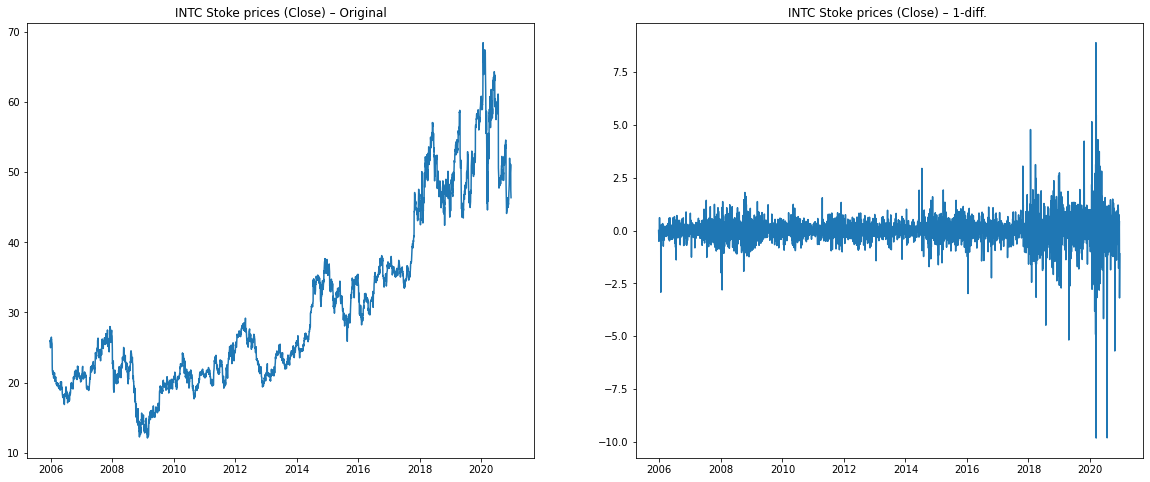

In [ ]:
d=1
intc_ts = intc_StockData.diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.plot(intc_StockData)
ax1.set_title(ts_title + ' – Original')
ax2.plot(intc_ts)
ax2.set_title(ts_title + ' – {}-diff. '.format(d));

#####<h4><strong>Результат</strong></h4>
$d=1$ <br>
`P-value` ниже уровня значимости $(0.05)$ было получено в ходе расширенного теста Дики—Фуллера с константой, но без тренда, (`regression='c'`) и первым порядком разности ($d=0$): <br><br>
$$ \Delta X_t = b_0 + b X_{t-1} + \varepsilon_t $$
<br>

---


Поскольку `P-value` оказалось ниже уровня значимости, мы можем отвергнуть нулевую гипотезу, заключающуюся в том, что ряд – нестационарен. <br>

#### <h3><strong>2.2. Параметр $p$</strong></h3>
Параметр $p$ – порядок авторегрессии (*AR*) в модели ARIMA. <br>
$p$ относится к числу лагов, которые будут использоваться в качестве предикторов. Для определения необходимого количества лагов, посмотрим на график частной автокорреляционной функции (`PACF` - partial autocorrelation function) для ряда разностей порядка $d$. Частная автокорреляционная функция представляет собой корреляцию между рядом и его лагами.

В теории, для процесса авторегрессии порядка  $𝑝$  значения частной автокорреляционной функции равны нулю для всех  $𝜏>𝑝$. 
$$ {PACF}_p=0 \; \forall 𝜏>𝑝  $$ 
<br>
Таким образом, используя график частной автокорреляционной функции для временного ряда разностей порядка  $𝑑$ , можно оценить параметр  $𝑝$  как значение лага  $𝜏$  (значение по оси абсцисс), после которого значения частной автокорреляционной функции равны (или почти равны) нулю.

Естественно, такой метод оценки не является абсолютно точным. В случае, когда нельзя однозначно определить, поске какого лага  $𝜏$  все значения частной автокорреляции можно считать нулевыми, можно выбрать несколько (в нашем случае – $2$) значений-кандидатов параметра  $𝑝$ , построить несколько моделей ARIMA с выбранными параметрами и выбрать, какая из них лучше.

Mожно использовать функцию `statsmodels.graphics.tsaplots.plot_pacf`

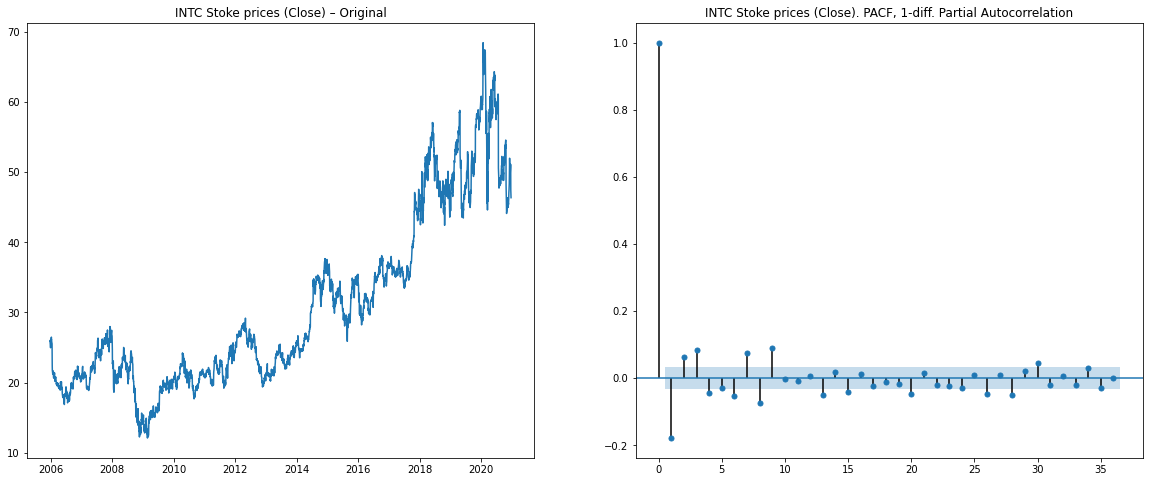

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.plot(intc_StockData)
ax1.set_title(ts_title + ' – Original')
plot_pacf(intc_ts, ax=ax2, title=ts_title + '. PACF, {}-diff. Partial Autocorrelation'.format(d))
plt.show()

График частной автокорреляции (`PACF`) содержит один явно ненулевой коэффициент для лага 0, а дальше все коэффициенты колеблются возле нуля. <br>
Такая картина походит случайное блуждание (<i>Random Walk</i>).

##### **Результат** 
Из графика частной автокорреляционной функции `PACF` получаем значение параметра $p=0$

#### <h3><strong>2.3. Параметр $q$</strong></h3>
Аналогично, чтобы оценить порядок скользящего среднего (*MA*) в модели ARIMA, нужно построть график автокорреляционной функции (`acf`) для ряда разностей порядка  $d$ (в нашем случае $d=1$).

<h4>Автокорреляционная функция (ACF)</h4>
<p><i>ACF</i> показывает степень линейной статистической связи между значениями временного ряда. <br>Численно, автокорреляционная функция представляет собой последовательность коэффициентов корреляции между исходным рядом, и его копией, сдвинутой на заданное число интервалов ряда (<i>лаг</i>).
Так, автокорелляционная функция имеет вид: <br>
$$ f(L)=\sum_{L=0}^n r_{t, t-L} $$

> $L$ – лаг <br>
> $n$ – число членов временного ряда <br>
> $r$ – коэффициент корелляции
</p>

На графике автокорреляционной функции `INTC (Close). ACF` мы наблюдаем нисходящий тренд, означающий убывание авторегрессии.

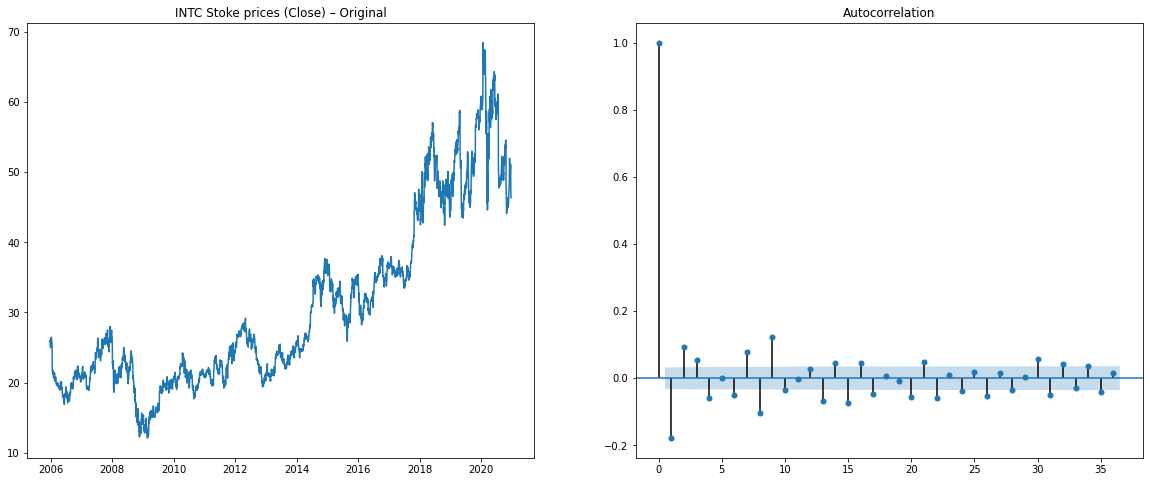

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.plot(intc_StockData)
ax1.set_title(ts_title + ' – Original')
plot_acf(intc_ts, ax=ax2);

##### <h4><strong>Результат</strong></h4>
Из графика автокорреляции получаем параметр $q=0$<br>График автокорреляции очень похож на случайное блуждание (<i>Random Walk</i>):
$$ X_t = X_{t-1} + \varepsilon_t $$
> $\varepsilon_t$ – гауссов белый шум<br>
<p>Значит, имеем дело с чистой авторегрессией (без скользящего среднего, $q = 0$), причём нестационарной.</p>

#### <h3><strong>2.4. Итого, параметры $d,p,q$</strong><h3>
Построив графики автокорреляции (`ACF`) и частной автокорреляции (`PACF`) для ряда разностей первого порядка, мы получили $p=0$ и $q=0$

Получается, мы должны построить модель ARIMA(0, 1, 0). <br>
Проще говоря, временной ряд первых разностей моделируется просто белым шумом.

> $d = 0 $  
> $p = 1 $  
> $q = 0 $  


### 3. Обучение

In [ ]:
df = intc_StockData
df = df.resample("D").last()

In [ ]:
model = ARIMA(df, order=(1,1,0), trend='ctt', freq='D').fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


### 4. Прогноз

Text(0.5, 1.0, 'INTC Stoke prices (Close)')

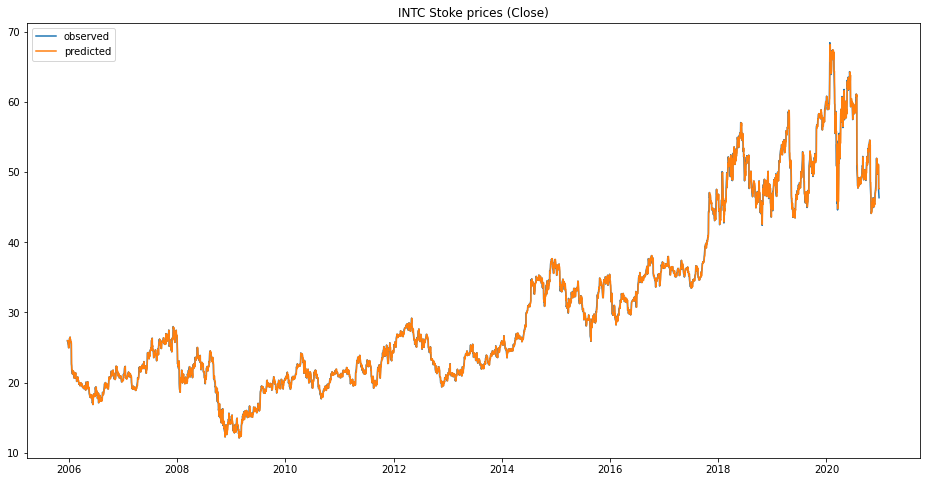

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(intc_StockData, color='tab:blue', label='observed')
plt.plot(model.predict(start=1), color='tab:orange', label='predicted')
plt.legend()
plt.title(ts_title)


#### 4.2. Предсказание на несколько шагов

In [ ]:
prediction_steps = 32
prediction_dates = pd.date_range(start='2020-12-01', periods=prediction_steps, freq='D')
print(prediction_dates)
prediction = pd.DataFrame(model.predict(start=prediction_dates[0], end=prediction_dates[-1], dynamic=True))
print(prediction)

DatetimeIndex(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20',
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30', '2020-12-31', '2021-01-01'],
              dtype='datetime64[ns]', freq='D')
            predicted_mean
2020-12-01       48.337683
2020-12-02       48.342740
2020-12-03       48.346862
2020-12-04       48.351036
2020-12-05       48.355208
2020-12-06       48.359381
2020-12-07       48.363556
2020-12-08       48.367733
2020-12-09       48.371911
2020-12-10       48.376090
2020-12-11       48.380270
2020-12-12       48.384452
2020-12-13       48.388635
2020-

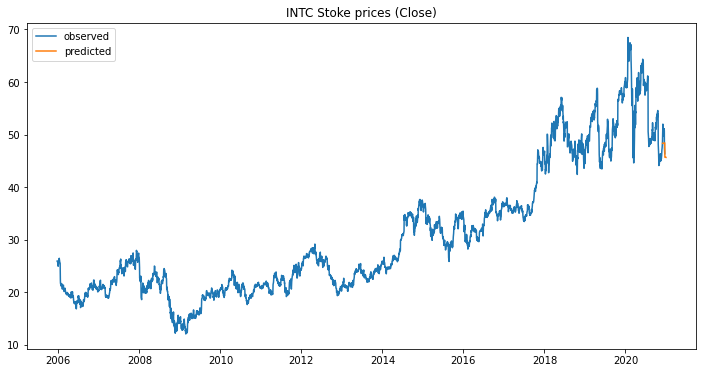

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(intc_StockData, color='tab:blue', label='observed')
plt.plot(prediction, color='tab:orange', label='predicted')
plt.legend()
plt.title(ts_title)
plt.show()